## Market Making at the Touch with Short-Term Alpha  (Chap 10.4.2)

This file implements the optimal acquisition strategy when a trader has a maximum price that they are willing to pay for the asset. The theory is covered in Chapter 7.2 of

Algorithmic and High-Frequency Trading (c) Cartea, Jaimungal, & Penalva, 2015 Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

### Introduction

In this section, we cover the optimal market making strategy of a trader who accounts for short-term alpha, i.e., short term predictions of the drift. The details of the model are covered in Chapter 10.4.2 and summarized here.

The asset's midprice is assumed to be given by

\begin{equation}
S_t = S_0 + \int_0^t (\upsilon+ \alpha_u)\,du + \sigma \,W_t
\end{equation}

where the drift constains a (constant) long-term component $\upsilon$ and a (stochastic) short-term component $\alpha_t$ that mean-reverts to zero.  

The trader wishes to solve for optimal postings at the touch (the best bid and ask prices) while accounting for the influence of short-term-alpha. The case without short-term aplha is covered in section 10.2.2.  

Let $\ell_t^{\pm} \in \{0,1\}$ denote whether the agent is posted on the sell side $(+)$ or the buy side $(-)$ of the LOB. For a given strategy $\ell^\pm$, the trader's performance criteria is  

\begin{equation}
\mathbb{E}\left[X_T^\ell + Q_T^\ell(S_T - (\tfrac{\Delta}{2} + \varphi\, Q_T^\ell))-\phi\int_0^T(Q_u^\ell)^2 du \right],
\end{equation}

and her cash process $X_t^l$ satisfies the SDE

\begin{equation}
dX_t^\ell = (S_t + \tfrac{\Delta}{2}dN_t^{+,\ell})-(S_t - \tfrac{\Delta}{2}dN_t^{-,\ell}),
\end{equation}

where $N^{\pm,\ell}_t$ denote the counting process corresponding to trader's filled buy / sell limit orders using the strategy $\ell$.

Moreover, the short-term alpha component is assumed to satisfy the SDE

\begin{equation}
d\alpha_t=-\zeta\,\alpha_t\,dt+ \eta \,dW_t^\alpha + \epsilon^+_{1+M_{t^-}^+} dM_t^+ - \epsilon^+_{1+M_{t^-}^-} dM_t^-
\end{equation}

where $M_t^\pm$ denote the counting process corresponding to the arrival of Market buy and sell orders, and $\epsilon_1^\pm,\epsilon_2^pm,\dots$ are iid random variables representing the jump in alpha when a market sell/buy order arrives.

### The Resulting DPE
As shown in  Chapter 10.4.2, applying the dynamic programming principle to the value function $H$, and writing $H(t,x,S,\alpha,q)=x+q\,S+h(t,\alpha,q)$ we demonstrate that $h$ satisfies the non-liner PDE

\begin{equation}
\begin{aligned}
0 = \big ( \partial_t - \zeta \alpha \partial_{\alpha} + \tfrac{1}{2}\eta^2 \partial_{\alpha \alpha}  \big )h + \alpha q - \phi q^2 \hspace{15em}
\\
+ \lambda^{+} \max\limits_{\ell^+\in \{0,1\}} \left\{ \textbf{1}_{q > f\underline{q}} \mathbb{E}\big [\ell^+ \tfrac{\Delta}{2} + h(t, \alpha + \epsilon^+, q - \ell^+) - h(t, \alpha + \epsilon^+, q) \big ] \right \} 
\\
+ \lambda^{-} \max\limits_{\ell^-\in \{0,1\}} \left\{ \textbf{1}_{q < \overline{q}} \mathbb{E}\big [\ell^- \tfrac{\Delta}{2} + h(t, \alpha - \epsilon^-, q + \ell^-) - h(t, \alpha - \epsilon^-, q) \big ] \right \} 
\\
+ \lambda^{+} \mathbb{E}[h(t, \alpha + \epsilon^+, q) - h(t, \alpha, q)] + \lambda^{-} \mathbb{E}[h(t, \alpha - \epsilon^-, q) - h(t, \alpha, q)] ,
\end{aligned}
\end{equation}

subject to the terminal condition

\begin{equation}
h(T, \alpha, q) = -q (\tfrac{\Delta}{2} + \varphi q)
\end{equation}

and the trader's optimal postings can be characterised as

\begin{equation}
\ell^{+,*}(t,q,\alpha) = \textbf{1}_{\big \{ \frac{\Delta}{2} + \mathbb{E}[h(t, \alpha + \epsilon^+, q-1) - h(t, \alpha + \epsilon^+, q)] > 0 \big \} \cap \big \{ q > \underline{q} \big \}} ,
\end{equation}

\begin{equation}
\ell^{-,*}(t,q,\alpha) = \textbf{1}_{\big \{ \frac{\Delta}{2} + \mathbb{E}[h(t, \alpha - \epsilon^-, q+1) - h(t, \alpha - \epsilon^-, q)] > 0 \big \} \cap \big \{ q < \overline{q} \big \}} .
\end{equation}

We next implement the solution to this DPE and run simulations along the optimal path.

In [ ]:
# import necessary libraries
import numpy as np
import math
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab

# import import_ipynb
import short_term_alpha_helpers as sta_helpers

params = {'legend.fontsize': 10,
          'figure.figsize': (8, 4),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 15,
         'ytick.labelsize': 15}
pylab.rcParams.update(params)

### Sample Results
For the purpose of focusing on the effect of short-term-alpha, we set the running penalty $\phi = 0$, and the remaining model parameters are
\begin{equation}
T = 60sec, \overline{q} = -\underline{q}=20, \lambda^{\pm} = 0.8333, \Delta = 0.01, \phi = 0.01, 
\eta = 0.001, \zeta = 0.5, \epsilon = 0.002 (constant)
\end{equation}

Then we use the above parameters to solve the DPE for $h$, the optimal postings $\ell^\pm$, and visualize the results below.

In [2]:
T = 60
POV = 0.2
Nq = 20

# Short-term alpha parameters
zeta = 0.5
epsilon = 0.002
eta = 0.001

Delta = 0.01
varphi = 0.01

# Running penalty
phi = 0

# Price volatility
sigma = 0.005

lambda_p = 0.5 * Nq / POV / T # 0.833
lambda_m = 0.5 * Nq / POV / T # 0.833

Ndt = math.floor((lambda_p + lambda_m) * T * 5) # 500

dt = T / Ndt # 0.12

short_term_alpha = sta_helpers.ShortTermAlpha(zeta, epsilon, eta)
short_term_alpha.generate_dalpha(dt, lambda_p, lambda_m)
short_term_alpha.generate_alpha(0.02, 4)

# Inventory Vector
q = np.arange(-Nq, Nq + 1, 1) 

# Time Vector
t = np.arange(0, T + dt, dt)

# The DPE is solved in the helper file
h, lp, lm = sta_helpers.generate_h_matrix(short_term_alpha, q, t, Delta, varphi, dt, phi, lambda_p, lambda_m)

lp_b, lm_b = sta_helpers.generate_sell_buy_posts(short_term_alpha, t, q, lp, lm)  # 27*501   Nalpha*Ndt

Processing: 10 percent completed.
Processing: 20 percent completed.
Processing: 30 percent completed.
Processing: 40 percent completed.
Processing: 50 percent completed.
Processing: 60 percent completed.
Processing: 70 percent completed.
Processing: 80 percent completed.
Processing: 90 percent completed.


KeyboardInterrupt: 

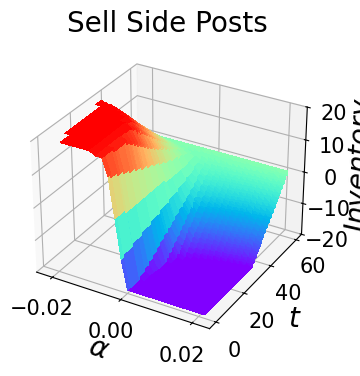

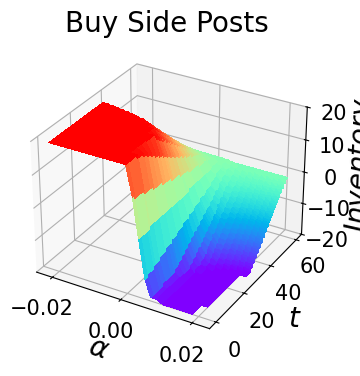

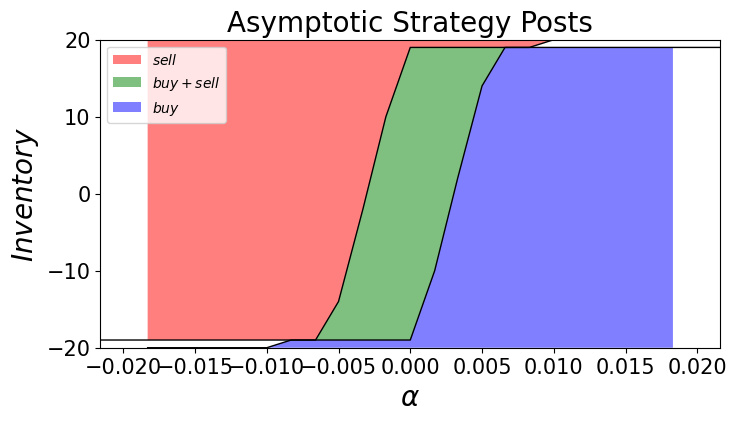

In [ ]:
sta_helpers.plot_post_surface(t, np.flip(short_term_alpha.value), lp_b, q, title="Sell Side Posts")
sta_helpers.plot_post_surface(t, np.flip(short_term_alpha.value), lm_b, q, title="Buy Side Posts")

sta_helpers.plot_optimal_posting(short_term_alpha.value, lp_b, lm_b, title="Asymptotic Strategy Posts")

## Simulating Sample Paths
We now simulate paths forward in time with the trader posting according to the optimal strategy found above

In [ ]:
Nsims = 1000
# Update the limit orders this often
dt_limit = 1/10

X_path, q_path, alpha_path, s_path, lm_path, lp_path, isMO, buySellMO = sta_helpers.generate_simulation(Nsims, t, dt, Delta,sigma, lambda_p, lambda_m, short_term_alpha, lm, lp, Nq, varphi)

Processing: 0 percent completed.
Processing: 10 percent completed.
Processing: 20 percent completed.
Processing: 30 percent completed.
Processing: 40 percent completed.
Processing: 50 percent completed.
Processing: 60 percent completed.
Processing: 70 percent completed.
Processing: 80 percent completed.
Processing: 90 percent completed.
done!


Next visulize the simulation results

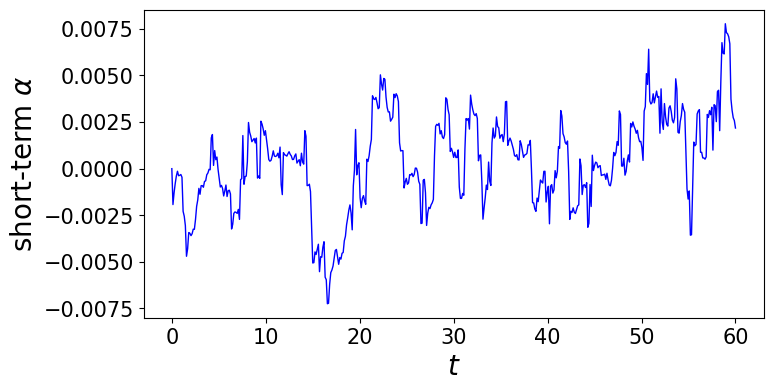

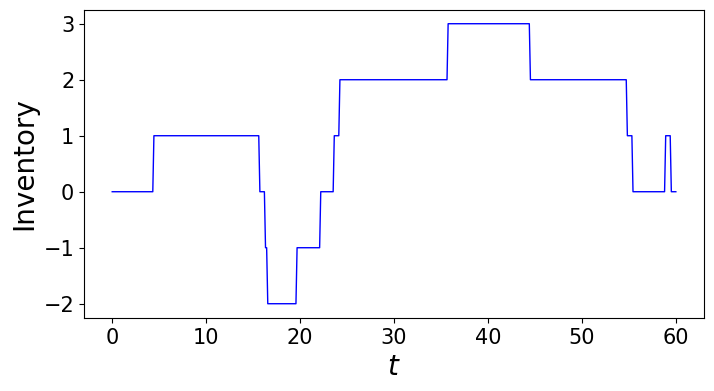

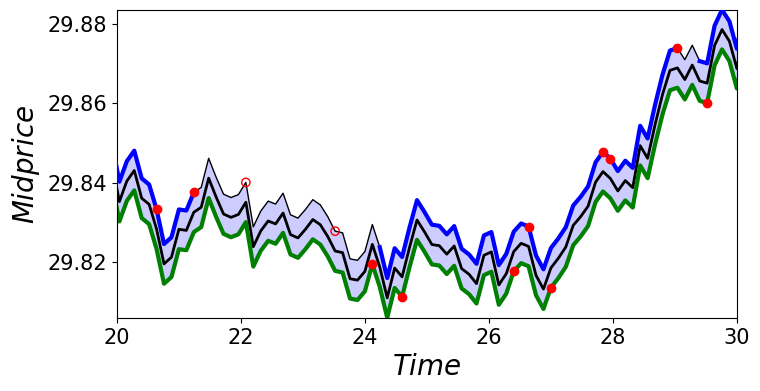

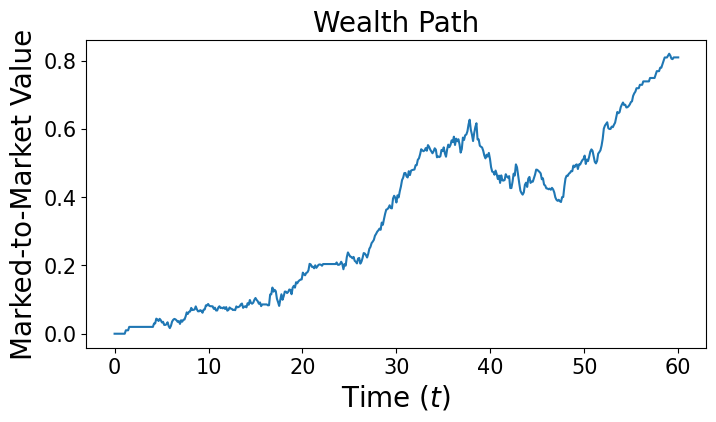

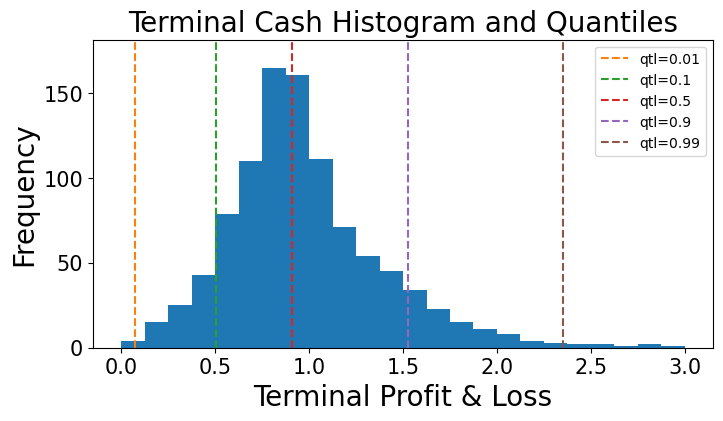

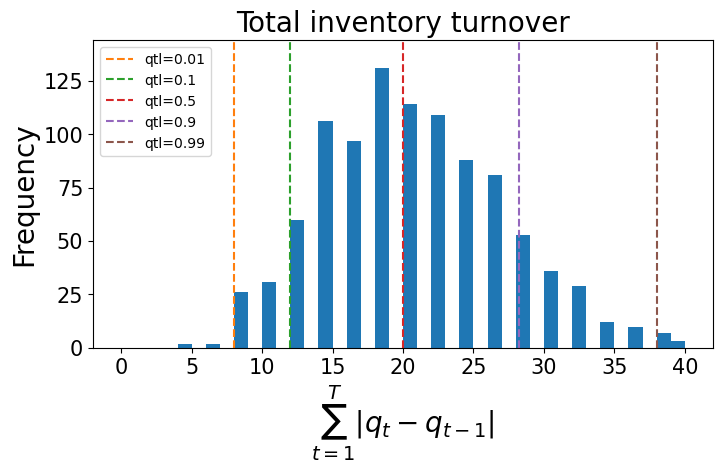

In [ ]:
# Which path of the simulations is selected to plot?
which_path = 30

sta_helpers.plot_simulation(t, alpha_path[which_path, ], r'$t$', r'short-term $\alpha$')
sta_helpers.plot_simulation(t, q_path[which_path, ], r'$t$', r'Inventory')

sta_helpers.plot_simulation_decision(Delta, t, s_path[which_path, ], lm_path[which_path, ], lp_path[which_path, ], isMO[which_path, ], buySellMO[which_path, ], zoom=(20, 30))
sta_helpers.plot_wealth_hist(t, X_path, q_path, s_path, which_path)
sta_helpers.plot_turnover_hist(q_path)